In [1]:
%matplotlib inline
import glob
import re
import json
import itertools

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

mpl.rc('font', family='Arial', size=12)

/Users/cimprich/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
with open('../../pair_counts.json') as f:
    total_read_counts = json.load(f)

In [3]:
with open('../../mean_spikein_counts.json') as f:
    mean_spike_counts = json.load(f)

In [4]:
spike_counts = pd.read_csv('../../spike_in_counts_bwa.tsv', sep = '\t', 
                           names = ('template', 'read_count', 'sample_name'))

spikein_matrix = (spike_counts.groupby(['sample_name', 'template']).read_count.mean().unstack().fillna(0) //2)

In [5]:
repeat_files = glob.glob('../../genome_correlations/repeats/all_repeats/*.cov')

In [6]:
bed_names = ['chr', 'start', 'end', 'name', 'count', 'strand']
repeat_data = {
    re.findall('/([^/]+)\.([mp])\.cov', f)[0]: 
    pd.read_csv(f, sep='\t', 
                names = bed_names + [re.findall('/([^/]+)\.([mp])\.cov', f)[0][0]]) 
    for f in repeat_files 
}

In [7]:
combined = pd.DataFrame({
    'chr': repeat_data[('aqr_1', 'p')].chr,
    'start': repeat_data[('aqr_1', 'p')].start,
    'end': repeat_data[('aqr_1', 'p')].end,
    'name': repeat_data[('aqr_1', 'p')].name,
    'strand': repeat_data[('aqr_1', 'p')].strand,
    'dmso_2_sense': repeat_data[('dmso_2', 'p')].dmso_2,
    'dmso_3_sense': repeat_data[('dmso_3', 'p')].dmso_3,
    'drb_2_sense': repeat_data[('drb_2', 'p')].drb_2,
    'drb_3_sense': repeat_data[('drb_3', 'p')].drb_3,
    'dmso_2_antisense': repeat_data[('dmso_2', 'm')].dmso_2,
    'dmso_3_antisense': repeat_data[('dmso_3', 'm')].dmso_3,
    'drb_2_antisense': repeat_data[('drb_2', 'm')].drb_2,
    'drb_3_antisense': repeat_data[('drb_3', 'm')].drb_3,
})

In [8]:
set(combined.name)

{'RNA:RNA:7SK',
 'rRNA:rRNA:5S',
 'rRNA:rRNA:LSU-rRNA_Hsa',
 'rRNA:rRNA:SSU-rRNA_Hsa',
 'scRNA:scRNA:BC200',
 'scRNA:scRNA:HY1',
 'scRNA:scRNA:HY3',
 'scRNA:scRNA:HY4',
 'scRNA:scRNA:HY5',
 'snRNA:snRNA:U1',
 'snRNA:snRNA:U13',
 'snRNA:snRNA:U13_',
 'snRNA:snRNA:U14',
 'snRNA:snRNA:U17',
 'snRNA:snRNA:U2',
 'snRNA:snRNA:U3',
 'snRNA:snRNA:U4',
 'snRNA:snRNA:U5',
 'snRNA:snRNA:U6',
 'snRNA:snRNA:U7',
 'snRNA:snRNA:U8',
 'srpRNA:srpRNA:7SLRNA',
 'tRNA-Deu:SINE:AmnSINE2',
 'tRNA-RTE:SINE:MamSINE1',
 'tRNA:SINE:LFSINE_Vert',
 'tRNA:SINE?:CRP1',
 'tRNA:tRNA:tRNA-Ala-GCA',
 'tRNA:tRNA:tRNA-Ala-GCG',
 'tRNA:tRNA:tRNA-Ala-GCY',
 'tRNA:tRNA:tRNA-Ala-GCY_',
 'tRNA:tRNA:tRNA-Arg-AGA',
 'tRNA:tRNA:tRNA-Arg-AGG',
 'tRNA:tRNA:tRNA-Arg-CGA',
 'tRNA:tRNA:tRNA-Arg-CGA_',
 'tRNA:tRNA:tRNA-Arg-CGG',
 'tRNA:tRNA:tRNA-Arg-CGY',
 'tRNA:tRNA:tRNA-Arg-CGY_',
 'tRNA:tRNA:tRNA-Asn-AAC',
 'tRNA:tRNA:tRNA-Asn-AAT',
 'tRNA:tRNA:tRNA-Asp-GAY',
 'tRNA:tRNA:tRNA-Cys-TGY',
 'tRNA:tRNA:tRNA-Gln-CAA',
 'tRNA:tRNA:tRNA-G

In [9]:
combined.to_csv('combined_count_repeats.tsv', sep='\t', index=False)

In [10]:
for sample in ['dmso_2', 'dmso_3', 'drb_2', 'drb_3']:
    combined.loc[combined.strand == "-", f"{sample}_sense"] = repeat_data[(sample, 'm')].loc[combined.strand == "-", f"{sample}"]
    combined.loc[combined.strand == "-", f"{sample}_antisense"] = repeat_data[(sample, 'p')].loc[combined.strand == "-", f"{sample}"]

In [11]:
combined = combined[~combined.name.str.contains('SINE')]

In [12]:
len(combined)

12446

In [13]:
combined.head()

,chr,dmso_2_antisense,dmso_2_sense,dmso_3_antisense,dmso_3_sense,drb_2_antisense,drb_2_sense,drb_3_antisense,drb_3_sense,end,name,start,strand
0,chr1,0,1,2,0,0,0,0,0,157886,snRNA:snRNA:U6,157783,-
1,chr1,0,1,1,0,1,1,1,0,516478,snRNA:snRNA:U6,516375,-
2,chr1,4,2,9,6,5,10,7,10,629570,tRNA:tRNA:tRNA-Gln-CAA_,629498,-
3,chr1,15,39,23,54,15,47,17,36,632685,tRNA:tRNA:tRNA-Ser-TCA(m),632618,-
4,chr1,0,0,1,1,0,0,0,0,758335,snRNA:snRNA:U6,758232,-


In [14]:
combined[combined.name.str.contains('LSU')].sort_values('dmso_2_sense').tail()

,chr,dmso_2_antisense,dmso_2_sense,dmso_3_antisense,dmso_3_sense,drb_2_antisense,drb_2_sense,drb_3_antisense,drb_3_sense,end,name,start,strand
11008,chr21,342,209,372,242,672,401,511,383,8218941,rRNA:rRNA:LSU-rRNA_Hsa,8214772,+
11021,chr21,409,210,408,252,712,450,609,406,8446211,rRNA:rRNA:LSU-rRNA_Hsa,8442036,+
19825,chrM,21471,216,13089,348,27792,458,16486,386,2745,rRNA:rRNA:LSU-rRNA_Hsa,2589,+
11018,chr21,410,217,436,254,727,409,580,351,8401980,rRNA:rRNA:LSU-rRNA_Hsa,8397806,+
19845,chrUn_GL000220v1,439,234,413,254,769,439,594,407,118417,rRNA:rRNA:LSU-rRNA_Hsa,114238,+


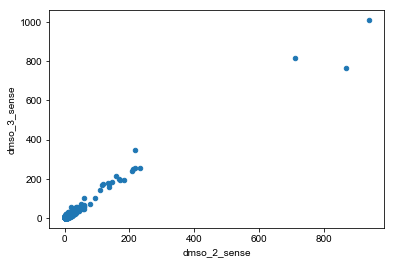

In [15]:
combined.plot.scatter('dmso_2_sense', 'dmso_3_sense')

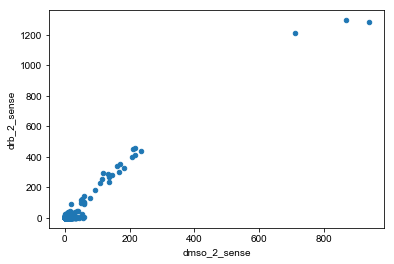

In [16]:
combined.plot.scatter('dmso_2_sense', 'drb_2_sense')

In [17]:
combined[(combined.dmso_2_sense > 500)]

,chr,dmso_2_antisense,dmso_2_sense,dmso_3_antisense,dmso_3_sense,drb_2_antisense,drb_2_sense,drb_3_antisense,drb_3_sense,end,name,start,strand
19826,chrM,7059,710,4503,818,9506,1213,5579,1040,3307,tRNA:tRNA:tRNA-Leu-TTA(m),3229,+
19827,chrM,688,867,929,764,1290,1295,1074,934,4400,tRNA:tRNA:tRNA-Gln-CAA_,4328,-
19828,chrM,371,938,590,1010,671,1285,631,1134,7514,tRNA:tRNA:tRNA-Ser-TCA(m),7447,-


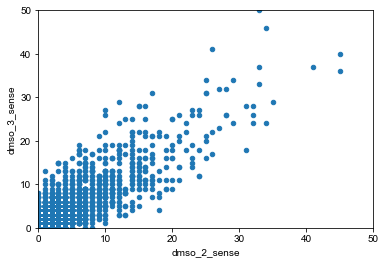

In [18]:
combined.plot.scatter('dmso_2_sense', 'dmso_3_sense', ylim=(0,50), xlim=(0,50))

In [19]:
stats.linregress(combined.loc[:, 'dmso_2_sense'], combined.loc[:, 'drb_3_sense']).slope

1.297522528144845

In [20]:
for s1, s2 in itertools.product(['dmso_2_sense', 'dmso_3_sense'], ['drb_2_sense', 'drb_3_sense']):
    print(s1,s2)

dmso_2_sense drb_2_sense
dmso_2_sense drb_3_sense
dmso_3_sense drb_2_sense
dmso_3_sense drb_3_sense


In [21]:
for s1, s2 in itertools.product(['dmso_2_sense', 'dmso_3_sense'], ['drb_2_sense', 'drb_3_sense']):
    print(stats.linregress(combined.loc[:, s1], combined.loc[:, s2]))

LinregressResult(slope=1.5402089212486676, intercept=-0.5410839604018447, rvalue=0.9727059324806671, pvalue=0.0, stderr=0.003293694956997701)
LinregressResult(slope=1.297522528144845, intercept=-0.23128268238804361, rvalue=0.9615193702201644, pvalue=0.0, stderr=0.0033234890653654685)
LinregressResult(slope=1.440642881569172, intercept=-0.6947282506881733, rvalue=0.9777522230328333, pvalue=0.0, stderr=0.002770618795675842)
LinregressResult(slope=1.2257725690987031, intercept=-0.38440506043872524, rvalue=0.9761657669464652, pvalue=0.0, stderr=0.002442972624543125)


In [22]:
normalization_factors = {
    sample :{
                'rdna' : stats.linregress(combined.loc[:, 'dmso_2_sense'], combined.loc[:, f"{sample}_sense"]).slope,
                'read_counts': total_read_counts[sample] / total_read_counts['dmso_2'],
                'spikein': (spikein_matrix.loc[sample, ['H281', 'L286']] / spikein_matrix.loc['dmso_2', ['H281', 'L286']]).mean()
                
            } for sample in ['dmso_2', 'dmso_3', 'drb_2', 'drb_3']
}

In [23]:
pivot_norm_factors = (pd.DataFrame(normalization_factors).T
                      .reset_index()
                      .rename(columns = {'index': 'sample_name'})
                      .melt(id_vars = 'sample_name', 
                            var_name = 'normalization_method', 
                            value_name = 'normalization_factor')
                     )

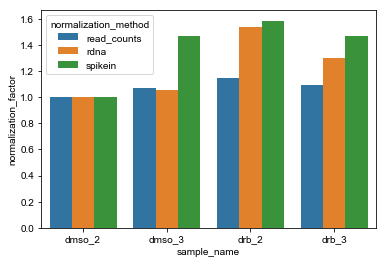

In [24]:
fig, ax = plt.subplots()

sns.barplot(
            x = 'sample_name',
            hue = 'normalization_method',
            y = 'normalization_factor',
            hue_order = [ 'read_counts', 'rdna', 'spikein'],
            data = pivot_norm_factors
           )

In [25]:
normalization_factors

{'dmso_2': {'rdna': 0.9999999999999998, 'read_counts': 1.0, 'spikein': 1.0},
 'dmso_3': {'rdna': 1.0578678071882572,
  'read_counts': 1.0733284445076505,
  'spikein': 1.4656866293900461},
 'drb_2': {'rdna': 1.5402089212486676,
  'read_counts': 1.1489838494457418,
  'spikein': 1.584782664242125},
 'drb_3': {'rdna': 1.297522528144845,
  'read_counts': 1.0964989749229004,
  'spikein': 1.4685238969257433}}

In [26]:
dmso_mean_data = (combined.dmso_2_sense + combined.dmso_3_sense) /2
drb_mean_data = (combined.drb_2_sense + combined.drb_3_sense) /2
mask = (dmso_mean_data > 10) & (drb_mean_data > 10) 
mask = (combined.chr != 'chrM')
dmso_mean_data_masked = dmso_mean_data[mask]
drb_mean_data_masked = drb_mean_data[mask]

In [27]:
mask.sum()

12442

In [28]:
dmso_mean_data_masked.mean()

1.6128435942774473

In [29]:
drb_mean_data_masked.mean()

1.7538177141938596

In [30]:
pd.DataFrame({
    'dmso': dmso_mean_data_masked,
    'drb': drb_mean_data_masked
}).to_csv('dmso_drb_data.tsv', sep='\t', index=False)

In [31]:
len(dmso_mean_data)

12446

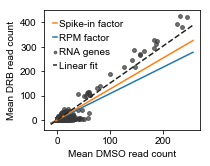

In [32]:
fig, ax = plt.subplots(figsize=(2.8,2.2))

model = stats.linregress(dmso_mean_data_masked, drb_mean_data_masked)
ax.scatter(dmso_mean_data_masked, drb_mean_data_masked, color = '#393939', label = 'RNA genes', alpha =0.7, s=15)
xlimits = ax.get_xlim()
slope_read_count = (total_read_counts['drb_2'] + total_read_counts['drb_3'])/(total_read_counts['dmso_2'] + total_read_counts['dmso_3'])
slope_spikein = (mean_spike_counts['drb_2'] + mean_spike_counts['drb_3'])/(mean_spike_counts['dmso_2'] + mean_spike_counts['dmso_3'])
ax.plot(xlimits, [slope_read_count * i for i in xlimits], linestyle='-', label = 'RPM factor')
ax.plot(xlimits, [slope_spikein * i for i in xlimits], linestyle='-', label = 'Spike-in factor')
ax.plot(xlimits, [model.slope * i for i in xlimits], linestyle='--', color = '#222222', label = 'Linear fit')
handles,labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
new_indices = [1,0,3,2]
for i in new_indices:
    new_handles.append(handles[i])
    new_labels.append(labels[i])
ax.legend(labels = new_labels, handles = new_handles, 
          frameon=False, handlelength=0.4, 
          markerscale=0.7, handletextpad=0.2,
          loc='upper left')
ax.set_xlabel('Mean DMSO read count')
ax.set_ylabel('Mean DRB read count')
fig.savefig('All_RNA_genes.svg')

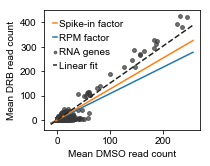

In [33]:
fig, ax = plt.subplots(figsize=(2.8,2.2))

model = stats.linregress(dmso_mean_data_masked, drb_mean_data_masked)
ax.scatter(dmso_mean_data_masked, drb_mean_data_masked, color = '#393939', label = 'RNA genes', alpha =0.7, s=15)
xlimits = ax.get_xlim()
slope_read_count = (total_read_counts['drb_2'] + total_read_counts['drb_3'])/(total_read_counts['dmso_2'] + total_read_counts['dmso_3'])
slope_spikein = (mean_spike_counts['drb_2'] + mean_spike_counts['drb_3'])/(mean_spike_counts['dmso_2'] + mean_spike_counts['dmso_3'])
ax.plot(xlimits, [slope_read_count * i for i in xlimits], linestyle='-', label = 'RPM factor')
ax.plot(xlimits, [slope_spikein * i for i in xlimits], linestyle='-', label = 'Spike-in factor')
ax.plot(xlimits, [model.slope * i for i in xlimits], linestyle='--', color = '#222222', label = 'Linear fit')
handles,labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
new_indices = [1,0,3,2]
for i in new_indices:
    new_handles.append(handles[i])
    new_labels.append(labels[i])
ax.legend(labels = new_labels, handles = new_handles, 
          frameon=False, handlelength=0.4, 
          markerscale=0.7, handletextpad=0.2,
          loc='upper left')
ax.set_xlabel('Mean DMSO read count')
ax.set_ylabel('Mean DRB read count')
fig.savefig('All_RNA_genes.svg')

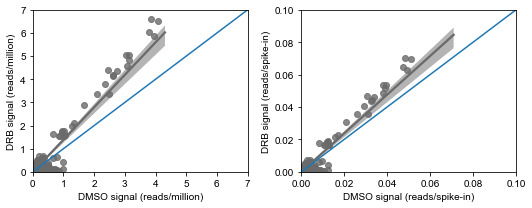

In [34]:
fig, ax = plt.subplots(ncols =2, figsize=(7.5,3))

norm_factor_read_count_drb = (total_read_counts['drb_2'] + total_read_counts['drb_3'])/2e6
norm_factor_read_count_dmso = (total_read_counts['dmso_2'] + total_read_counts['dmso_3'])/2e6
norm_factor_spikein_drb = (mean_spike_counts['drb_2'] + mean_spike_counts['drb_3'])
norm_factor_spikein_dmso = (mean_spike_counts['dmso_2'] + mean_spike_counts['dmso_3'])


sns.regplot(dmso_mean_data_masked/norm_factor_read_count_dmso, 
              drb_mean_data_masked/norm_factor_read_count_drb
            ,ax = ax[0], color = '#6a6a6a')

sns.regplot(dmso_mean_data_masked/norm_factor_spikein_dmso, 
              drb_mean_data_masked/norm_factor_spikein_drb,
            ax = ax[1], color = '#6a6a6a')

ax[0].set_xlim(0,7)
ax[0].set_ylim(0,7)
ax[0].set_xlabel('DMSO signal (reads/million)')
ax[0].set_ylabel('DRB signal (reads/million)')

ax[1].set_xlim(0,0.10)
ax[1].set_ylim(0,0.10)
ax[1].set_xlabel('DMSO signal (reads/spike-in)')
ax[1].set_ylabel('DRB signal (reads/spike-in)')

ax[0].plot([0, 7], [0,7])
ax[1].plot([0, 0.10], [0,0.10])

plt.setp(ax[0].collections[1], alpha=0.5)
plt.setp(ax[1].collections[1], alpha=0.5)
fig.tight_layout()
fig.savefig('compare_rpm_rps_over_all_rna_genes.svg')
fig.savefig('compare_rpm_rps_over_all_rna_genes.pdf')

In [35]:
?np.co

Object `np.co` not found.


In [39]:
def bootstrap_ci(x_data, y_data, n_boots):
    slopes = np.zeros(n_boots)
    for i in range(n_boots):
        if not i % 200:
            print(i/n_boots)
        idx = np.random.choice(len(x_data), len(x_data), replace=True)
        slopes[i] = sm.OLS(y_data.iloc[idx], x_data.iloc[idx]).fit().params['x1']
    return slopes
    

In [ ]:
boots_read_counts = bootstrap_ci(dmso_mean_data_masked/norm_factor_read_count_dmso, 
                                 drb_mean_data_masked/norm_factor_read_count_drb,
                                 500000
                                )

0.0
0.0004
0.0008
0.0012
0.0016
0.002
0.0024
0.0028
0.0032
0.0036
0.004
0.0044
0.0048
0.0052
0.0056
0.006
0.0064
0.0068
0.0072
0.0076
0.008
0.0084
0.0088
0.0092
0.0096
0.01
0.0104
0.0108
0.0112
0.0116
0.012
0.0124
0.0128
0.0132
0.0136
0.014
0.0144
0.0148
0.0152
0.0156
0.016
0.0164
0.0168
0.0172
0.0176
0.018
0.0184
0.0188
0.0192
0.0196
0.02
0.0204
0.0208
0.0212
0.0216
0.022
0.0224
0.0228
0.0232
0.0236
0.024
0.0244
0.0248
0.0252
0.0256
0.026
0.0264
0.0268
0.0272
0.0276
0.028
0.0284
0.0288
0.0292
0.0296
0.03
0.0304
0.0308
0.0312
0.0316
0.032
0.0324
0.0328
0.0332
0.0336
0.034
0.0344
0.0348
0.0352
0.0356
0.036
0.0364
0.0368
0.0372
0.0376
0.038
0.0384
0.0388
0.0392
0.0396
0.04
0.0404
0.0408
0.0412
0.0416
0.042
0.0424
0.0428
0.0432
0.0436
0.044
0.0444
0.0448
0.0452
0.0456
0.046
0.0464
0.0468
0.0472
0.0476
0.048
0.0484
0.0488
0.0492
0.0496
0.05
0.0504
0.0508
0.0512
0.0516
0.052
0.0524
0.0528
0.0532
0.0536
0.054
0.0544
0.0548
0.0552
0.0556
0.056
0.0564
0.0568
0.0572
0.0576
0.058
0.0584
0.0588
0

0.4852
0.4856
0.486
0.4864
0.4868
0.4872
0.4876
0.488
0.4884
0.4888
0.4892
0.4896
0.49
0.4904
0.4908
0.4912
0.4916
0.492
0.4924
0.4928
0.4932
0.4936
0.494
0.4944
0.4948
0.4952
0.4956
0.496
0.4964
0.4968
0.4972
0.4976
0.498
0.4984
0.4988
0.4992
0.4996
0.5
0.5004
0.5008
0.5012
0.5016
0.502
0.5024
0.5028
0.5032
0.5036
0.504
0.5044
0.5048
0.5052
0.5056
0.506
0.5064
0.5068
0.5072
0.5076
0.508
0.5084
0.5088
0.5092
0.5096
0.51
0.5104
0.5108
0.5112
0.5116
0.512
0.5124
0.5128
0.5132
0.5136
0.514
0.5144
0.5148
0.5152
0.5156
0.516
0.5164
0.5168
0.5172
0.5176
0.518
0.5184
0.5188
0.5192
0.5196
0.52
0.5204
0.5208
0.5212
0.5216
0.522
0.5224
0.5228
0.5232
0.5236
0.524
0.5244
0.5248
0.5252
0.5256
0.526
0.5264
0.5268
0.5272
0.5276
0.528
0.5284
0.5288
0.5292
0.5296
0.53
0.5304
0.5308
0.5312
0.5316
0.532
0.5324
0.5328
0.5332
0.5336
0.534
0.5344
0.5348
0.5352
0.5356
0.536
0.5364
0.5368
0.5372
0.5376
0.538
0.5384
0.5388
0.5392
0.5396
0.54
0.5404
0.5408
0.5412
0.5416
0.542
0.5424
0.5428
0.5432
0.5436
0.544
0

In [ ]:
boots_spikeins = bootstrap_ci(dmso_mean_data_masked/norm_factor_spikein_dmso, 
                                 drb_mean_data_masked/norm_factor_spikein_drb,
                                 500000
                                )

In [74]:
boots_spikeins[0:10]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

AttributeError: module 'numpy' has no attribute 'perecentile'

In [40]:
np.percentile(boots_spikeins, 2.5), np.mean(boots_spikeins), np.percentile(boots_spikeins, 97.5)


(1.0621968433843287, 1.1694809155378176, 1.2427273292544758)

In [41]:
np.percentile(boots_read_counts, 2.5), np.mean(boots_read_counts), np.percentile(boots_read_counts, 97.5)

(1.2472177418828203, 1.3730801940940975, 1.459024171643122)

In [46]:
(boots_read_counts <= boots_spikeins).mean()

0.005806

In [50]:
ax[0].get_children()[1]

 Text(0.5,1,''),
 Text(0,1,''),
 Text(1,1,''),

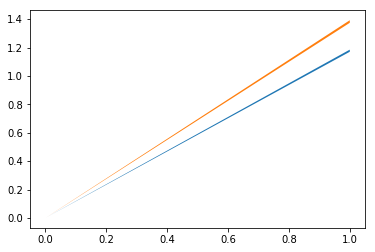

In [48]:
fig, ax = plt.subplots()

x = np.linspace(0, 1, 10)

ax.fill_between(x, 1.170*x, 1.185*x)
ax.fill_between(x, 1.374*x, 1.392*x)

In [43]:
norm_factor_read_count_dmso, norm_factor_read_count_drb

(59.7154585, 64.6738035)

In [44]:
norm_factor_spikein_dmso, norm_factor_spikein_drb

(4775.5, 6073.0)

In [37]:
m_read_counts = sm.OLS(drb_mean_data_masked/norm_factor_read_count_drb, dmso_mean_data_masked/norm_factor_read_count_dmso)
m_spikeins = sm.OLS(drb_mean_data_masked/norm_factor_spikein_drb, dmso_mean_data_masked/norm_factor_spikein_dmso)

In [59]:
_ = m_read_counts.fit()

In [60]:
_.params

x1    1.38271
dtype: float64

In [41]:
print(m_spikeins.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 8.682e+04
Date:                Tue, 21 May 2019   Prob (F-statistic):               0.00
Time:                        11:58:58   Log-Likelihood:                 72828.
No. Observations:               12442   AIC:                        -1.457e+05
Df Residuals:                   12441   BIC:                        -1.456e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1776      0.004    294.644      0.0